# Simple Example

Consider the following graphical Model,
```mermaid
flowchart TD
	S[(sigma)]--->X
	L[(lambda)]--->Z
	Z((Z))--->X[X]
```
Here we have a latent variable Z and a observed variable X. There are two controlling parameter $\sigma$ and $\lambda$ which are just included for completeness the more important relation ship is that of between $Z$ and $X$.
```mermaid
flowchart TD
	Z((Z))--->X[X]
```
Where,
$$
\begin{align}
Z &\sim Exp(\lambda)\\
X &\sim \mathcal{N}(\mu=Z,\sigma=1)
\end{align}
$$
and our task is to estimate $Z$ based on the observed $X$ that is we are interested in $p(Z|X)$.
$$
\begin{align}
p(Z) &= e^{-Z}\cdot I(Z\geq0)\\
p(X|Z) &= \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}
\end{align}
$$
Now,

$$
\begin{align}
p(X, Z) &= P(X|Z)P(Z)\\
&=e^{-Z}\cdot \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}I(Z\geq0)
\end{align}
$$
This gives us that that the marginal or total probability $p(X)$ is given by.

$$
\begin{align}
p(X) &= \int_0^\infty {p(X,Z)\; dZ}\\
&= \int_0^\infty {e^{-Z}\cdot \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}\; dZ}\\
\end{align}
$$


In [34]:
from scipy.stats import norm,expon
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact,widgets
from IPython.display import display

In [35]:
def prob_Z(Z):
    return expon.pdf(Z)
def prob_X_given_Z(X,Z):
    return norm.pdf(X,loc=Z,scale=1)

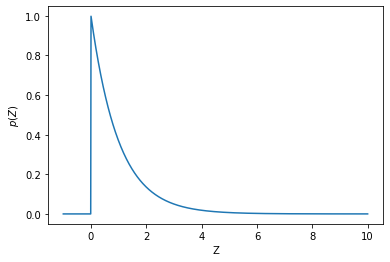

In [36]:
test_Z_space = np.linspace(-1,10,1000)
test_X_space = np.linspace(-10,10,1000)
# prob_Z(test_Z_space)
plt.ylabel('$p(Z)$')
plt.xlabel('Z')
plt.plot(test_Z_space,prob_Z(test_Z_space))
plt.show()

In [37]:
out = widgets.Output()
@interact(Z=(0,10))
def plot_x_given_Z(Z):
    prob = prob_X_given_Z(test_X_space,Z)
    with out:
        plt.ylabel('$p(X|Z)$')
        plt.xlabel('X')
        out.clear_output(wait=True)
        plt.plot(test_X_space,prob)
        plt.show()
display(out)

interactive(children=(IntSlider(value=5, description='Z', max=10), Output()), _dom_classes=('widget-interact',…

Output()

In [38]:
out = widgets.Output()
@interact(X=(-1,5))
def plot_Z_given_X_unnormalized(X):
    prob = prob_X_given_Z(X,test_Z_space)*prob_Z(test_Z_space)
    with out:
        plt.ylabel('$p^*(Z|X)$')
        plt.xlabel('Z')
        out.clear_output(wait=True)
        plt.plot(test_X_space,prob)
        plt.show()
display(out)

interactive(children=(IntSlider(value=2, description='X', max=5, min=-1), Output()), _dom_classes=('widget-int…

Output()